In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt
from scipy import stats 

colors = viz.plotting_style()
lin_colors = colors.values()
plt.style.use('style.mpl')

color_order = ['green', 'blue', 'red', 'purple', 'yellow', 'dark_green', 'dark_blue', 'dark_brown']
lin_colors = [colors[c] for c in color_order]

In [2]:
phi_df = pd.read_csv('../output/Fig2A_variable_lambda.csv')
zcorg_sensitivity_df = pd.read_csv('../output/Fig2B_variable_ZCred.csv')

auto_comp_df = pd.read_csv('../output/Fig2C_autotrophy_samples.csv')
hetero_comp_df = pd.read_csv('../output/Fig2C_heterotrophy_samples.csv')
# Concatentate the two dataframes
comp_df = pd.concat([auto_comp_df, hetero_comp_df])
comp_df

,oxidation_kcat_s,oxidation_m_kDa,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,cyclic_flow_kcat_s,cyclic_flow_m_kDa,ZCB,ZCorg,...,ATP_homeostasis_flux,analytic_lambda_zo,analytic_lambda_max_zo,S6_lb_zo,S6_ub_zo,ZCorg_lb_zo,ZCorg_ub_zo,model,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa
0,200.0,1725.809598,50.0,211.201275,50.0,1481.521486,50.0,1000.0,0.0,0.0,...,0.0,0.000000,-0.000000e+00,-0.686770,-0.686780,0.40002,1.142773,autotrophy,NaN,NaN
1,200.0,859.075163,50.0,629.942886,50.0,1851.664144,50.0,1000.0,0.0,0.0,...,0.0,0.000000,-0.000000e+00,-1.724342,-1.724336,0.40002,1.142773,autotrophy,NaN,NaN
2,200.0,2037.163883,50.0,686.251995,50.0,3286.599373,50.0,1000.0,0.0,0.0,...,0.0,0.000000,2.445667e-15,-1.290667,-1.290664,0.40002,1.142773,autotrophy,NaN,NaN
3,200.0,5329.296903,50.0,414.206074,50.0,3182.668145,50.0,1000.0,0.0,0.0,...,0.0,0.000000,9.155481e-16,-0.477772,-0.477793,0.40002,1.142773,autotrophy,NaN,NaN
4,200.0,773.179709,50.0,837.620232,50.0,220.132752,50.0,1000.0,0.0,0.0,...,0.0,0.000000,-3.831048e-15,-0.227779,-0.227771,0.40002,1.142773,autotrophy,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,50.0,200.320738,200.0,1527.014327,50.0,467.087349,NaN,NaN,0.0,0.0,...,0.0,4.451700,4.451700e+00,0.349764,-2.798071,-0.30002,1.499883,heterotrophy,50.0,1000.0
96,50.0,1384.475511,200.0,378.697843,50.0,2686.694098,NaN,NaN,0.0,0.0,...,0.0,0.924312,9.243125e-01,0.291098,-2.329665,-0.30002,1.499883,heterotrophy,50.0,1000.0
97,50.0,1332.155797,200.0,1183.983133,50.0,1401.584006,NaN,NaN,0.0,0.0,...,0.0,1.651653,1.651653e+00,0.157827,-1.262837,-0.30002,1.499883,heterotrophy,50.0,1000.0
98,50.0,1005.633515,200.0,1066.037831,50.0,2442.495623,NaN,NaN,0.0,0.0,...,0.0,1.004412,1.004412e+00,0.364332,-2.914824,-0.30002,1.499883,heterotrophy,50.0,1000.0


estimated lambda_max: 2.592
actual lambda_max: 2.287042625886344


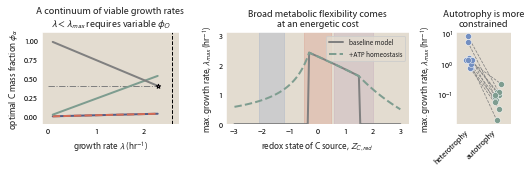

In [3]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(7.24, 2.5),
                        gridspec_kw=dict(width_ratios=[0.75, 1, 0.3]))

# Estimate lambda_max from simple relationships
min_phi_O = 0.4
g_ana = phi_df.anabolism_gamma.values[0]
est_lambda_max = 12*3600*g_ana*(1-min_phi_O)
lambda_max = phi_df.lambda_hr.max()
print('estimated lambda_max:', est_lambda_max)
print('actual lambda_max:', lambda_max)

plt.sca(axs[0])

# Line at min_phi_O
min_phi_O = 0.4
plt.plot([0, lambda_max], [min_phi_O, min_phi_O], 
         color='grey', ls='-.', lw=1)
#plt.text(1.1, min_phi_O+0.03, r'min. $\phi_O$', ha='center', fontsize=9)

x = phi_df['lambda_hr']
# Not plotting homeostasis because it was set to zero
cmap = dict(oxidation=colors['dark_blue'],
            reduction=colors['red'],
            anabolism=colors['dark_green'],
            other='grey')
processes = 'oxidation,reduction,anabolism'.split(',')
process_labels = dict(
    oxidation=r'$\phi_{ox}$',
    reduction=r'$\phi_{red}$',
    anabolism=r'$\phi_{ana}$',
    other=r'$\phi_O$')
phi_cols = ['{}_phi'.format(p) for p in processes] + ['phi_O']
for i, col in enumerate(phi_cols):
    label = processes[i] if i < len(processes) else r'other'
    legend_label = process_labels[label]
    c = cmap[label]
    ls = '--' if label == 'reduction' else '-'
    plt.plot(x, phi_df[col], label=legend_label, color=c, ls=ls)
plt.scatter([lambda_max], [min_phi_O], color=colors['purple'], edgecolor='k', marker='*', zorder=10, s=20)

plt.axvline(est_lambda_max, color='k', ls='--', lw=1) 
#plt.text(est_lambda_max-0.02, 0.3, r'$\lambda_{max} \approx \gamma_{ana}(1-\phi_O)$', ha='right', va='center', rotation=90, fontsize=9)
plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'optimal C mass fraction $\phi_\alpha$')   
#plt.legend(loc=1)
plt.ylim(-0.1, 1.1)

plt.sca(axs[1])
phi_H_included = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == False]
no_phi_H = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey',
         label=r'baseline model'.format(min_phi_O))
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr,
         color=colors['dark_green'], ls='--',
         label=r'+ATP homeostasis', zorder=10)

plt.axvspan(-2.1, -1.2, color=colors['blue'], alpha=0.2, zorder=-10)
plt.axvspan(-0.5, 0.5, color=colors['red'], alpha=0.2, zorder=-10)
plt.axvspan(0.6, 2, color=colors['purple'], alpha=0.2, zorder=-10)

plt.legend(loc=1)
plt.ylim(0, 3.1)
plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.ylabel(r'max. growth rate, $\lambda_{max}$ (hr$^{-1}$)')

plt.sca(axs[2])
plt.yscale('log')
# Plot the pairs of growth rates calculated with the same sampled params
# Note: we are neglecting max growth rates that are very low for heterotrophy
# since this is implausible in the first place.
mask = (hetero_comp_df.lambda_hr > 0.05)
idxs = hetero_comp_df[mask].index[:10]
auto_examples = auto_comp_df.iloc[idxs].copy()
np.random.seed(23)
auto_examples['x_pos'] = 1 + np.random.normal(0, 0.07, size=10)
hetero_examples = hetero_comp_df.iloc[idxs].copy()
hetero_examples['x_pos'] = 0 + np.random.normal(0, 0.07, size=10)

sns.scatterplot(data=auto_examples, x='x_pos', y='lambda_hr', color=colors['dark_green'])
sns.scatterplot(data=hetero_examples, x='x_pos', y='lambda_hr', color=colors['blue'])
for i in range(10):
    auto_ex = auto_examples.iloc[i]
    hetero_ex = hetero_examples.iloc[i]
    plt.plot([hetero_ex.x_pos, auto_ex.x_pos], [hetero_ex.lambda_hr, auto_ex.lambda_hr],
             color='grey', lw=0.75, zorder=0, ls='--')

plt.xticks([0, 1], ['heterotrophy', 'autotrophy'], ha='right', rotation=45)
plt.ylabel(r'max. growth rate, $\lambda_{max}$ (hr$^{-1}$)')
plt.xlim(-0.5, 1.5)
plt.xlabel('')

titles = [
    'A continuum of viable growth rates\n $\lambda < \lambda_{max}$ requires variable $\phi_O$',
    'Broad metabolic flexibility comes\nat an energetic cost',
    'Autotrophy is more\nconstrained'
]
for title, label, ax in zip(titles, 'ABC', axs):
    #ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_title(title)
    
plt.tight_layout()
plt.savefig('../output/Fig2.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

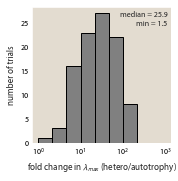

In [4]:
# extract the pairs of growth rates calculated with the same sampled params
cols = 'lambda_hr,model'.split(',')
data = np.vstack([auto_comp_df.lambda_hr.values, hetero_comp_df.lambda_hr.values]).T
auto_comp_lambdas = pd.DataFrame(data, columns='auto_lambda_hr,hetero_lambda_hr'.split(','))
auto_comp_lambdas['fc'] = auto_comp_lambdas.hetero_lambda_hr / auto_comp_lambdas.auto_lambda_hr
auto_comp_lambdas

# Plot the distribution of the fold change in growth rate
fig, ax = plt.subplots(figsize=(2.5, 2.5))
bins = np.logspace(0, 3, 10)
plt.xscale('log')
plt.hist(auto_comp_lambdas.fc, bins=bins, color='grey', edgecolor='k')
median_fc = auto_comp_lambdas.fc.median()
min_fc = auto_comp_lambdas.fc.min()
max_fc = auto_comp_lambdas.fc.max()
plt.text(0.97, 0.97, 'median = {0:.1f}\nmin = {1:.1f}'.format(
            median_fc, min_fc, max_fc),
         ha='right', va='top', fontsize=8, transform=ax.transAxes)
plt.xlabel('fold change in $\lambda_{max}$ (hetero/autotrophy)')
plt.ylabel('number of trials')
plt.show()

In [15]:
auto_var_zcred_df = pd.read_csv('../output/FigSX_autotrophy_ZCred.csv')
auto_var_zcred_df['lambda_hr,ZCorg'.split(',')]

,lambda_hr,ZCorg
0,0.000000,-2.00
1,0.000000,-1.95
2,0.000000,-1.90
3,0.000000,-1.85
4,0.000000,-1.80
...,...,...
76,0.068031,1.80
77,0.067500,1.85
78,0.066977,1.90
79,0.066462,1.95


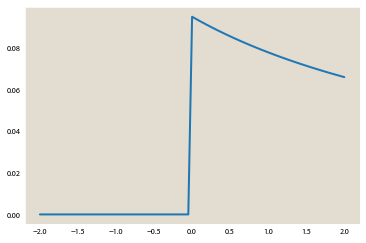

In [16]:
plt.plot(auto_var_zcred_df.ZCorg, auto_var_zcred_df.lambda_hr)

In [6]:
var_phi_O_df = pd.read_csv('../output/Fig2S1_variable_phi_O.csv')
var_g_ana_df = pd.read_csv('../output/Fig2S1_variable_g_ana.csv')
var_g_red_df = pd.read_csv('../output/Fig2S1_variable_g_red.csv')


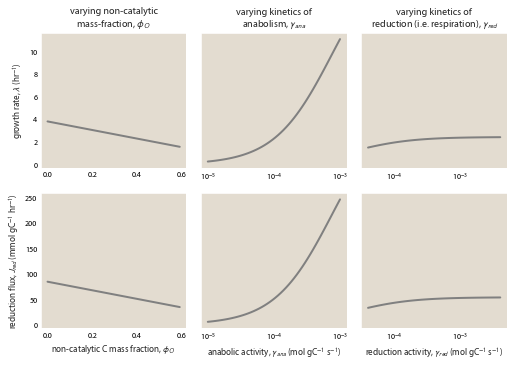

In [7]:
# Supplementary figure focusing on respiratory rates
# TODO: add variable stoichiometry, e.g. S4, to these panels
# TODO: calculate CUE and plot that as well
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7.24, 5.2), sharey='row')

# Left panel: varying phi_O
# Model can use ATP homeostasis to maximize growth
# TODO: convert fluxes to per hr
mask = var_phi_O_df['opt.max_phi_H_set'] == False
masked = var_phi_O_df[mask]

plt.sca(axs[0,0])
plt.plot(masked.phi_O, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.ylabel(r'growth rate, $\lambda$ (hr$^{-1}$)')
plt.title('varying non-catalytic\nmass-fraction, $\phi_O$')
plt.sca(axs[1,0])
plt.plot(masked.phi_O, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.ylabel(r'reduction flux, $J_{red}$ (mmol gC$^{-1}$ hr$^{-1}$)')
plt.xlabel(r'non-catalytic C mass fraction, $\phi_O$')

# Middle panels: varying anabolism gamma
mask = var_g_ana_df['opt.max_phi_H_set'] == False
masked = var_g_ana_df[mask]

plt.sca(axs[0,1])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\nanabolism, $\gamma_{ana}$')
plt.sca(axs[1,1])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel(r'anabolic activity, $\gamma_{ana}$ (mol gC$^{-1}$ s$^{-1}$)')

# Right panels: varying anabolism gamma
mask = var_g_red_df['opt.max_phi_H_set'] == False
masked = var_g_red_df[mask]

plt.sca(axs[0, 2])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\n reduction (i.e. respiration), $\gamma_{red}$')
plt.sca(axs[1, 2])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel(r'reduction activity, $\gamma_{red}$ (mol gC$^{-1}$ s$^{-1}$)')

plt.tight_layout()
plt.savefig('../output/Fig2S1.png', facecolor='white', bbox_inches='tight', dpi=300)

In [8]:
masked

,oxidation_kcat_s,oxidation_m_kDa,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,ZCB,ZCorg,...,opt.fixed_ra,opt.fixed_re,opt.rate_law_name,opt.rate_law_order,analytic_lambda_zo,analytic_lambda_max_zo,S6_lb_zo,S6_ub_zo,ZCorg_lb_zo,ZCorg_ub_zo
0,50.0,1000.0,200.0,100.000000,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,2.414896,2.414896,0.15001,-1.202630,-0.30002,1.499883
2,50.0,1000.0,200.0,109.854114,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,2.413419,2.413419,0.15001,-1.202394,-0.30002,1.499883
4,50.0,1000.0,200.0,120.679264,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,2.411798,2.411798,0.15001,-1.202180,-0.30002,1.499883
6,50.0,1000.0,200.0,132.571137,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,2.410020,2.410020,0.15001,-1.201984,-0.30002,1.499883
8,50.0,1000.0,200.0,145.634848,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,2.408070,2.408070,0.15001,-1.201806,-0.30002,1.499883
10,50.0,1000.0,200.0,159.985872,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,2.405932,2.405932,0.15001,-1.201644,-0.30002,1.499883
12,50.0,1000.0,200.0,175.751062,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,2.403587,2.403587,0.15001,-1.201497,-0.30002,1.499883
14,50.0,1000.0,200.0,193.069773,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,2.401016,2.401016,0.15001,-1.201362,-0.30002,1.499883
16,50.0,1000.0,200.0,212.095089,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,2.398198,2.398198,0.15001,-1.201240,-0.30002,1.499883
18,50.0,1000.0,200.0,232.995181,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,2.395110,2.395110,0.15001,-1.201129,-0.30002,1.499883
